In [7]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from glob import glob

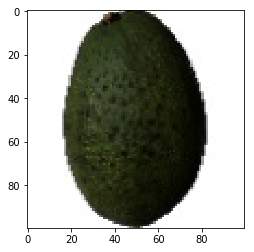

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [8]:
image_size = [100,100]

epochs = 2
batch_size = 32

train_path = './large_files/fruits-360-small/Training'
valid_path = './large_files/fruits-360-small/Validation'

# to get number of files
image_files = glob(train_path + '/*/*.jp*g')
#print(image_files)
valid_image_files = glob(valid_path + '/*/*.jp*g')

# to get number of classes
folders = glob(train_path + '/*')

plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

# We need to provide the input dimension of the images to the vgg model, here the image dimensions are appended with 3 
# which stands for the number of channels.
# pretrained weights of imagenet dataset are used instead of random initialization and include_top is false which 
# means that we want everything except the last layer of the vgg since we'll build our own liner classifier on top of this
vgg_model = VGG16(input_shape=image_size+[3], weights='imagenet', include_top=False)

# don't train the vgg layers , they're already trained
for layer in vgg_model.layers:
    layer.trainable = False

x = Flatten()(vgg_model.output)
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=prediction)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -91.26535 max: <built-in method max of numpy.ndarray object at 0x00000161A7A1A0D0>


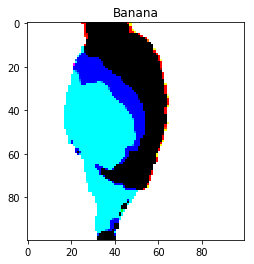

Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.
Epoch 1/2
119/119 [==============================] - 333s 3s/step - loss: 5.2814 - acc: 0.6588 - val_loss: 4.1578 - val_acc: 0.7401
Epoch 2/2
119/119 [==============================] - 330s 3s/step - loss: 4.1441 - acc: 0.7402 - val_loss: 4.1346 - val_acc: 0.7432


In [9]:
# Snippet taken from keras docs.
generator = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,
                               zoom_range=0.2,horizontal_flip=True,vertical_flip=True,
                               preprocessing_function=preprocess_input)


test_generator = generator.flow_from_directory(valid_path, target_size=image_size)
print(test_generator.class_indices)
labels = [None] * len(test_generator.class_indices)
for k,v in test_generator.class_indices.items():
    labels[v] = k

for x,y in test_generator:
    print("min:",x[0].min(),'max:',x[0].max)
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

train_generator = generator.flow_from_directory(train_path,target_size=image_size,shuffle=True,batch_size=batch_size)
valid_generator = generator.flow_from_directory(valid_path,target_size=image_size,shuffle=True,batch_size=batch_size)

r = model.fit_generator(train_generator,validation_data=valid_generator,epochs=epochs,
                               steps_per_epoch=len(image_files)//batch_size,validation_steps=len(valid_image_files)//batch_size)


model.save('vgg_transfer.h5')

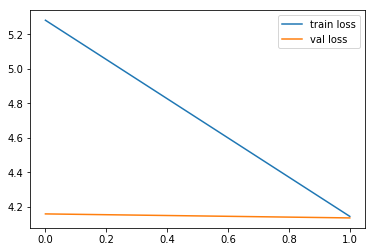

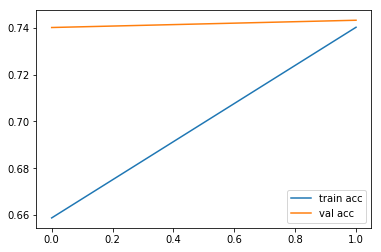

In [10]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix",N)
    predictions = []
    targets = []
    i=0
    for x,y in generator.flow_from_directory(data_path,target_size=image_size,shuffle=False,batch_size=batch_size*2):
        i+=1
        if i%50==0:
            print(i)
            p = model.predict(x)
            p = np.argmax(p, axis=1)
            y = np.argmax(y, axis=1)
            predictions = np.concatenate((predictions,p))
            targets = np.concatenate((targets,y))
            if len(targets) >= N:
                break
    
    cm = confusion_matrix(targets, predictions)
    return cm

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()